In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import bz2
import _pickle as cPickle

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='default', context='notebook', ticks=True, grid=False)
plt.style.use('default')

In [220]:
filepath = '../data/mfp-diaries.tsv'

# import dataset as pandas.DataFrame
import json
with open(filepath) as f:
    data = pd.read_csv(f, sep='\t', header = None)

data.rename(columns = {0: 'user_id', 1: 'date', 2: 'food_entries', 3: 'intakes_goals'}, inplace=True)

In [4]:
# read i-th row
i = 40000
user_id = data.iloc[i,0]
date = data.iloc[i,1]
food_entries = json.loads(data.iloc[i, 2])
aggregate_intake_goal = json.loads(data.iloc[i,3])

In [5]:
user_id

674

In [6]:
date

'2015-02-25'

In [7]:
food_entries

[{'meal': 'Breakfast',
  'dishes': [{'nutritions': [{'name': 'Calories', 'value': '2'},
     {'name': 'Carbs', 'value': '0'},
     {'name': 'Sat Fat', 'value': '0'},
     {'name': 'Protein', 'value': '0'},
     {'name': 'Chol', 'value': '0'},
     {'name': 'Vit C', 'value': '0'}],
    'name': 'Coffee - Brewed from grounds, 1 cup (8 fl oz)'},
   {'nutritions': [{'name': 'Calories', 'value': '27'},
     {'name': 'Carbs', 'value': '0'},
     {'name': 'Sat Fat', 'value': '1'},
     {'name': 'Protein', 'value': '0'},
     {'name': 'Chol', 'value': '0'},
     {'name': 'Vit C', 'value': '0'}],
    'name': 'Deli Continental - Smooth Reduced Fat Brussels Pâté, 13 g'},
   {'nutritions': [{'name': 'Calories', 'value': '58'},
     {'name': 'Carbs', 'value': '11'},
     {'name': 'Sat Fat', 'value': '0'},
     {'name': 'Protein', 'value': '2'},
     {'name': 'Chol', 'value': '0'},
     {'name': 'Vit C', 'value': '0'}],
    'name': 'Greenhalghs - Honey and Sunflower Bread, 1 slice from small 400g loa

In [10]:
aggregate_intake_goal

{'total': [{'name': 'Calories', 'value': 1278},
  {'name': 'Carbs', 'value': 188},
  {'name': 'Sat Fat', 'value': 12},
  {'name': 'Protein', 'value': 43},
  {'name': 'Chol', 'value': 6},
  {'name': 'Vit C', 'value': 4}],
 'goal': [{'name': 'Calories', 'value': 1310},
  {'name': 'Carbs', 'value': 164},
  {'name': 'Sat Fat', 'value': 15},
  {'name': 'Protein', 'value': 66},
  {'name': 'Chol', 'value': 300},
  {'name': 'Vit C', 'value': 100}]}

In [190]:
# import pathlib

# def create_folder(p):
#     pathlib.Path(p).mkdir(parents=True, exist_ok=True)
#     pathlib.Path(p+os.sep+'.gitkeep').touch()

# # root folder to put the many folders
# subpath = '../data'

# #loop over all values and create a folder for each possible date
# for i in range(data.shape[0]): 
#     this_path = subpath + os.sep + str(data.user_id[i]) + os.sep + str(data.date[i]) + os.sep
#     create_folder(this_path)
    
#     with open(this_path + 'food_entries.json', 'w') as f:
#         json.dump(data.food_entries[i], f)
        
#     with open(this_path + 'intakes_goals.json', 'w') as f:
#         json.dump(data.intakes_goals[i], f)

KeyError: 2

In [221]:
data.head()

,user_id,date,food_entries,intakes_goals
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [222]:
data.date = pd.to_datetime(data.date)

In [223]:
data.date.max() - data.date.min()

Timedelta('207 days 00:00:00')

In [194]:
num_days_logged = data.groupby('user_id').agg({'date': lambda x: (x.max() - x.min()).days + 1})

In [195]:
num_days_logged

,date
user_id,
1,180
2,60
3,10
4,133
5,177
...,...
9893,28
9894,166
9895,179


In [196]:
num_days_logged['date'].describe()

count    9891.000000
mean      115.019310
std        63.023556
min         1.000000
25%        61.000000
50%       137.000000
75%       175.000000
max       193.000000
Name: date, dtype: float64

In [197]:
data.intakes_goals = data.intakes_goals.astype(str)

In [224]:
# Focus on calories, carbs, protein, and fat intake
# ignore other nutrients for now, differs between users
def extract(ser, target):
    for i in range(len(ser)):
        if ser[i]['name'] == target:
            return ser[i]['value']
        
    return None

data['calorie_goal'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['goal'], 'Calories'))
data['carb_goal'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['goal'], 'Carbs'))
data['protein_goal'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['goal'], 'Protein'))
data['fat_goal'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['goal'], 'Fat'))

data['calorie_total'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['total'], 'Calories'))
data['carb_total'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['total'], 'Carbs'))
data['protein_total'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['total'], 'Protein'))
data['fat_total'] = data.intakes_goals.apply(lambda x: extract(json.loads(x)['total'], 'Fat'))

In [225]:
data.head()

,user_id,date,food_entries,intakes_goals,calorie_goal,carb_goal,protein_goal,fat_goal,calorie_total,carb_total,protein_total,fat_total
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}...",3173.0,396.0,160.0,105.0,2924.0,340.0,186.0,114.0
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}...",1572.0,196.0,79.0,52.0,2430.0,96.0,50.0,37.0
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}...",1832.0,229.0,92.0,61.0,1862.0,158.0,114.0,54.0
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}...",1685.0,210.0,85.0,56.0,2251.0,187.0,98.0,60.0
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}...",1597.0,199.0,80.0,53.0,2001.0,113.0,202.0,81.0


In [226]:
t = data.groupby('user_id')[['calorie_goal', 'carb_goal', 'protein_goal', 'fat_goal']].nunique()

In [227]:
t

,calorie_goal,carb_goal,protein_goal,fat_goal
user_id,,,,
1,168,120,76,61
2,16,17,16,15
3,4,4,3,3
4,25,24,18,17
5,34,0,31,27
...,...,...,...,...
9893,22,21,20,0
9894,1,1,1,1
9895,152,108,99,46


In [228]:
data.groupby('user_id').calorie_goal.nunique()

user_id
1       168
2        16
3         4
4        25
5        34
       ... 
9893     22
9894      1
9895    152
9896      3
9897     49
Name: calorie_goal, Length: 9896, dtype: int64

In [229]:
# Number of times calorie goal was changed
t.describe()

,calorie_goal,carb_goal,protein_goal,fat_goal
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,31.109539,22.252627,18.994442,14.561843
std,37.420116,24.198005,19.410089,13.876763
min,1.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,4.000000,3.000000
50%,16.000000,13.000000,12.000000,11.000000
75%,44.000000,33.000000,28.000000,22.000000
max,174.000000,139.000000,130.000000,123.000000


# Preprocessing
    - filter out users with at less than two weeks of data
    - filter out users with less than 20 days of meals logged
    - explore/remove users with outlying nutrition goals
        - dropped users with more than 10 days of calorie goals > 5000

In [230]:
user_data = pd.DataFrame()

# Frequency of days with meals logged by user
user_data['use_period'] = data.groupby('user_id').date.apply(lambda x: (x.max() - x.min()).days)
user_data['num_days_logged'] = data.groupby('user_id').date.count()
user_data['freq_logged'] = user_data['num_days_logged']/user_data['use_period']
user_data.reset_index(drop=False, inplace=True)
nusers = data.user_id.nunique()

In [231]:
data1 = data.copy()

In [232]:
# Drop users with usage period less than 2 weeks
drop = user_data.loc[user_data.use_period < 14].index
user_data.drop(index=drop, inplace=True)

# Drop users with less than 14 days of meal-logging
drop = user_data.loc[user_data['num_days_logged'] < 14].index
user_data.drop(index=drop, inplace=True)

data = data.loc[data.user_id.isin(user_data.user_id.unique())]

nusers1 = data.user_id.nunique()
print(f'{nusers-nusers1} users dropped')
print(f'{nusers1} users remaining')

2512 users dropped
7384 users remaining


In [233]:
# How many users without protein, carb, fat, and calorie goals?
users_with_nan_goals = data.loc[(data[['calorie_goal', 'carb_goal', 'protein_goal', 'fat_goal']].isna().sum(axis=1) == True)].user_id.unique()
num_nans_users = data.loc[data.user_id.isin(users_with_nan_goals), ['user_id', 'calorie_goal', 'carb_goal', 'protein_goal', 'fat_goal']].groupby('user_id').apply(lambda x: x.isna().sum())

# Number of nans for macronutrient goals for users
num_nans_users.head()

,user_id,calorie_goal,carb_goal,protein_goal,fat_goal
user_id,,,,,
5,0,0,179,0,0
25,0,0,30,0,0
31,0,0,180,0,0
168,0,0,0,130,0
173,0,0,127,0,0


In [234]:
num_nans_users.loc[num_nans_users.calorie_goal > 0]

,user_id,calorie_goal,carb_goal,protein_goal,fat_goal
user_id,,,,,


All users have calorie goals. As long as there is a calorie goal, I think we can keep these users even if they don't have main macronutrient goals.

<AxesSubplot:xlabel='calorie_goal', ylabel='Count'>

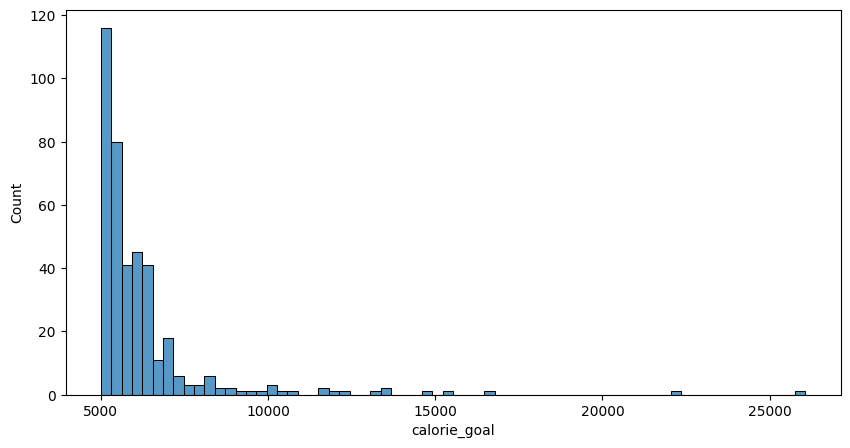

In [235]:
plt.figure(figsize=(10, 5))
sns.histplot(data.loc[data.calorie_goal > 5000, 'calorie_goal'])

In [236]:
# How many days did users have outlying calorie goals
t = data.loc[data.calorie_goal > 5000].groupby('user_id').calorie_goal.count()

In [237]:
t.describe()

count    136.000000
mean       2.897059
std        5.026271
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       39.000000
Name: calorie_goal, dtype: float64

In [238]:
t[t>10]

user_id
717     13
1543    33
3494    24
4143    14
6957    39
Name: calorie_goal, dtype: int64

In [239]:
t.describe()

count    136.000000
mean       2.897059
std        5.026271
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       39.000000
Name: calorie_goal, dtype: float64

In [240]:
# Drop these 5 users with greater than 10 days with calorie goals > 5000
drop = data.loc[data.user_id.isin(t[t>10].index.unique())].index
data.drop(index=drop, inplace=True)

In [241]:
data.head()

,user_id,date,food_entries,intakes_goals,calorie_goal,carb_goal,protein_goal,fat_goal,calorie_total,carb_total,protein_total,fat_total
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}...",3173.0,396.0,160.0,105.0,2924.0,340.0,186.0,114.0
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}...",1572.0,196.0,79.0,52.0,2430.0,96.0,50.0,37.0
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}...",1832.0,229.0,92.0,61.0,1862.0,158.0,114.0,54.0
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}...",1685.0,210.0,85.0,56.0,2251.0,187.0,98.0,60.0
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}...",1597.0,199.0,80.0,53.0,2001.0,113.0,202.0,81.0


In [242]:
print(f'{data.user_id.nunique()} users remaining')

7379 users remaining


In [247]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

compressed_pickle('cleaned', data) 

In [3]:
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

data = decompress_pickle('cleaned.pbz2') 

In [4]:
data.head()

,user_id,date,food_entries,intakes_goals,calorie_goal,carb_goal,protein_goal,fat_goal,calorie_total,carb_total,protein_total,fat_total
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}...",3173.0,396.0,160.0,105.0,2924.0,340.0,186.0,114.0
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}...",1572.0,196.0,79.0,52.0,2430.0,96.0,50.0,37.0
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}...",1832.0,229.0,92.0,61.0,1862.0,158.0,114.0,54.0
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}...",1685.0,210.0,85.0,56.0,2251.0,187.0,98.0,60.0
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}...",1597.0,199.0,80.0,53.0,2001.0,113.0,202.0,81.0


In [5]:
import json

In [6]:
# Do food entries sum to total intakes?
target = 'Calories'
sum_nutrient = 0
for entry in json.loads(data['food_entries'].iloc[0]):
    for nutrition in entry['dishes']:
        for nutrient in nutrition['nutritions']:
            if nutrient['name'] == target:
                sum_nutrient = sum_nutrient + int(nutrient['value'])
print(sum_nutrient)

2924


Yes

In [7]:
data.drop(index=data[data.calorie_goal > 7000].index, inplace=True)

In [8]:
data.drop(index=data[data.calorie_goal < 500].index, inplace=True)

In [9]:
data.calorie_goal.describe()

count    571448.000000
mean       1807.644832
std         513.912879
min         500.000000
25%        1451.000000
50%        1707.000000
75%        2045.000000
max        6990.000000
Name: calorie_goal, dtype: float64

Text(0.5, 1.0, 'Calorie Goals')

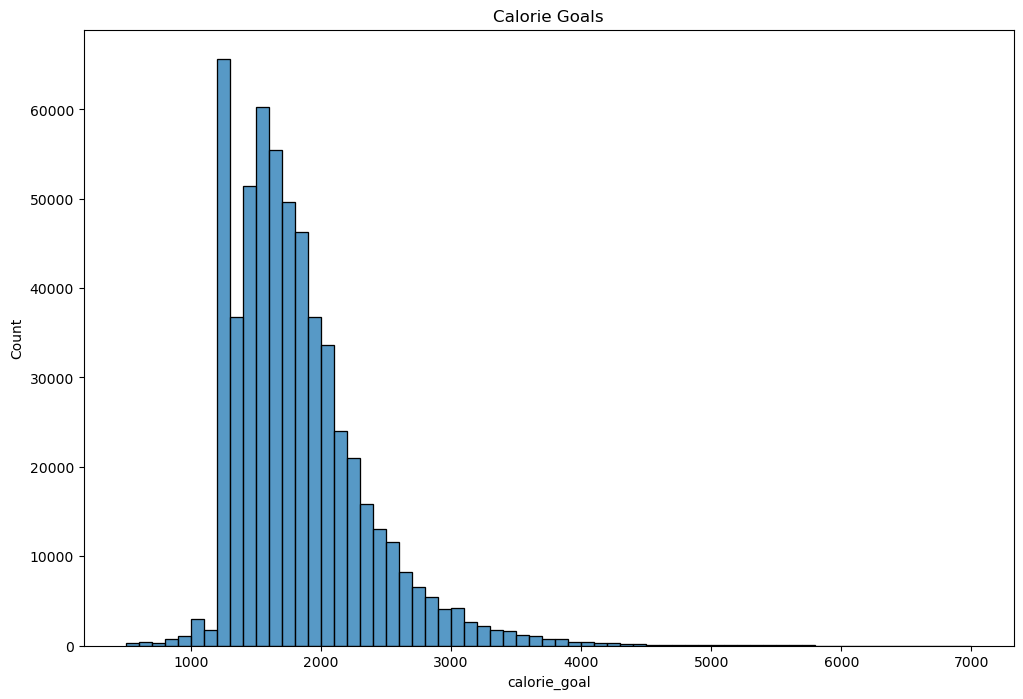

In [10]:
plt.figure(figsize=(12,8))
sns.histplot(data.calorie_goal, binwidth=100)
plt.title('Calorie Goals')

# What macronutrients are predictive of achieving goals

In [11]:
# Add feature: number of meals logged, number of unique foods logged
def count_foods(x):
    count = 0
    for meal in x:
        count += len(meal['dishes'])
    return count

data['meal_count'] = data.food_entries.apply(lambda x: json.loads(x)[-1]['sequence'])

data['item_count'] = data.food_entries.apply(lambda x: count_foods(json.loads(x)))

In [12]:
goaldata = data.drop(columns=['food_entries', 'intakes_goals'])

In [13]:
goaldata.user_id.nunique()

7378

In [14]:
#goaldata.loc[goaldata.isna().any(axis=1)].groupby('user_id').count()
drop_users = goaldata.loc[goaldata.isna().any(axis=1)].user_id.unique()
drop = goaldata[goaldata.user_id.isin(drop_users)].index
goaldata.drop(index=drop, inplace=True)

In [15]:
goaldata.shape[0]

538166

In [16]:
# Relative % of calories
goaldata['sum_cals'] = goaldata['carb_total']*4 + goaldata['protein_total']*4 + goaldata['fat_total']*9

# Filter so data includes best tracked macronutrients
goaldata = goaldata.loc[(goaldata['calorie_total'] - goaldata['sum_cals']) < 200]

In [17]:
goaldata['protein_pc'] = goaldata['protein_total']*4/goaldata['sum_cals'] * 100
goaldata['fat_pc'] = goaldata['fat_total']*9/goaldata['sum_cals'] * 100
goaldata['carb_pc'] = goaldata['carb_total']*4/goaldata['sum_cals'] * 100

In [18]:
# success if calories within 100 of goal
goaldata.loc[(abs(goaldata['calorie_goal'] - goaldata['calorie_total']) < 150), 'success'] = True
goaldata['success'] = goaldata['success'].fillna(False)

goaldata['dist_from_goal'] = goaldata['calorie_goal'] - goaldata['calorie_total']

In [19]:
goaldata.columns

Index(['user_id', 'date', 'calorie_goal', 'carb_goal', 'protein_goal',
       'fat_goal', 'calorie_total', 'carb_total', 'protein_total', 'fat_total',
       'meal_count', 'item_count', 'sum_cals', 'protein_pc', 'fat_pc',
       'carb_pc', 'success', 'dist_from_goal'],
      dtype='object')

In [20]:
drop = goaldata.loc[goaldata.isna().any(axis=1)].index
goaldata.drop(index=drop, inplace=True)

In [21]:
X_orig = goaldata[['meal_count', 'item_count', 'carb_pc', 'protein_pc', 'fat_pc', 'calorie_goal']]
y_orig = goaldata['success']
y_orig.value_counts()

False    357302
True     117930
Name: success, dtype: int64

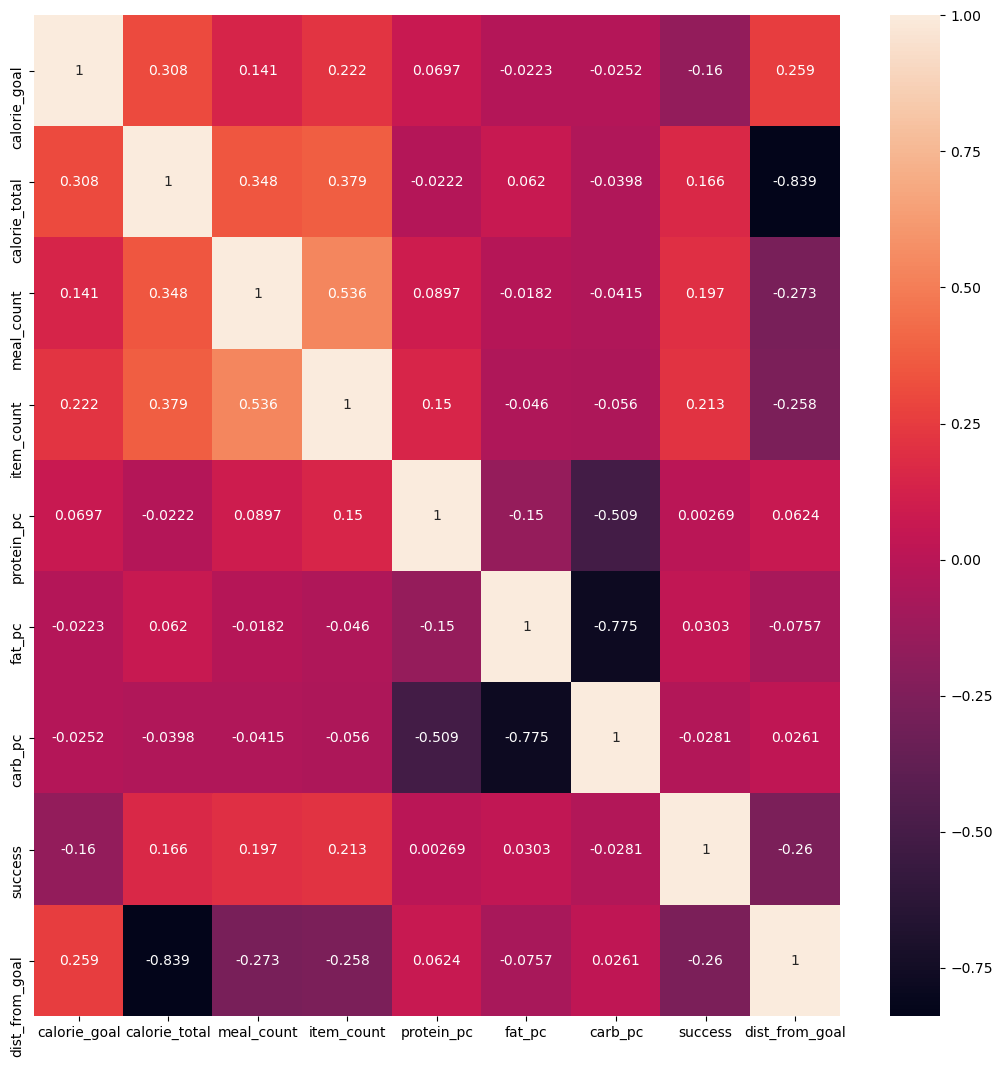

In [22]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# 'carb_goal', 'protein_goal', 'fat_goal','sum_cals','carb_total', 'protein_total', 'fat_total',
X_cov = ss.fit_transform(goaldata[['calorie_goal', 'calorie_total', 
       'meal_count', 'item_count',  'protein_pc', 'fat_pc',
       'carb_pc', 'success', 'dist_from_goal']])  #max_feats[ABILITY_COLS]
X_df = pd.DataFrame(X_cov)

#'carb_goal', 'protein_goal', 'fat_goal','sum_cals','carb_total', 'protein_total', 'fat_total',
X_df.columns=['calorie_goal', 'calorie_total', 
       'meal_count', 'item_count',  'protein_pc', 'fat_pc',
       'carb_pc', 'success', 'dist_from_goal']
cov_mat = X_df.cov()

plt.figure(figsize=(13,13))
sns.heatmap(cov_mat, annot=True, fmt='.3g')
plt.show()

### Handle Imbalanced classes


In [23]:
from sklearn.utils import resample
from sklearn.metrics import classification_report


In [24]:
# Oversample minority class
X_min = X_orig[y_orig == True]
y_min = y_orig[y_orig == True]
X_maj = X_orig[y_orig == False]
y_maj = y_orig[y_orig == False]

X_bal, y_bal = resample(X_min, 
                        y_min,
                        replace=True,
                        n_samples=X_orig[y_orig == False].shape[0],
                        random_state=123)

# Append the oversampled minority class to training data and related labels
X = pd.concat([X_maj, X_bal])
y = pd.concat([y_maj, y_bal])

In [25]:
# Undersample Majority Class
X_min = X_orig[y_orig == True]
y_min = y_orig[y_orig == True]
X_maj = X_orig[y_orig == False]
y_maj = y_orig[y_orig == False]

X_under, y_under = resample(X_maj, 
                        y_maj,
                        replace=False,
                        n_samples=X_orig[y_orig == True].shape[0],
                        random_state=123)

# Append the oversampled minority class to training data and related labels
X = pd.concat([X_under, X_min])
y = pd.concat([y_under, y_min])

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
ss = StandardScaler().fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier

def calc_scores(model, X_train, y_train, X_test, y_test, label='Logistic', plotroc=True):
    print('Test Accuracy: ' + str(model.score(X_test, y_test)))
    #Predict test data set.
    y_pred = model.predict(X_test)
    #Checking performance our model with classification report.
    print(classification_report(y_test, y_pred))
    #Checking performance our model with ROC Score.
    print('ROC Score: ')
    print(roc_auc_score(y_test, y_pred))

#     print(f'Score on test set: {model.score(X_test, y_test)}')
    
#     # no skill model, stratified random class predictions
#     dummy = DummyClassifier(strategy='stratified')
#     dummy.fit(X_train, y_train)
#     yhat = dummy.predict_proba(X_test)
#     pos_probs = yhat[:, 1]
#     # calculate roc auc
#     roc_auc = roc_auc_score(y_test, pos_probs)
#     print('No Skill ROC AUC %.3f' % roc_auc)
#     # skilled model
#     yhat = model.predict_proba(X_test)
#     pos_probs = yhat[:, 1]
#     # calculate roc auc
#     roc_auc = roc_auc_score(y_test, pos_probs)
#     print('Model ROC AUC %.3f' % roc_auc)
    
#     if plotroc == True:
#         # Plot confusion matrix
# #         plt.figure(figsize=(4,6))
# #         plot_confusion_matrix(model, X_test, y_test)  
# #         plt.show()  
    
    
#         plt.figure(figsize=(4,4))
#         # plot no skill roc curve
#         plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
#         # calculate roc curve for model
#         fpr, tpr, _ = roc_curve(y_test, pos_probs)
#         # plot model roc curve
#         plt.plot(fpr, tpr, marker='.')
#         plt.title(label)
#         # axis labels
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         # show the legend
#         plt.legend()
#         # show the plot
#         plt.show()

### Random Forest Clf

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth': range(20, 29)}
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=6)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print(f'Best score on kfold validation: {clf.best_score_}')
print(f'Best Params: {clf.best_params_}') 
tree_model.predict(X=X_test)
calc_scores(tree_model, X_train, y_train, X_test, y_test, label='Random Forest')

Best score on kfold validation: 0.6860212450443361
Best Params: {'max_depth': 20}
Test Accuracy: 0.688943183583544
              precision    recall  f1-score   support

       False       0.72      0.60      0.66     35189
        True       0.66      0.77      0.71     35618

    accuracy                           0.69     70807
   macro avg       0.69      0.69      0.69     70807
weighted avg       0.69      0.69      0.69     70807

ROC Score: 
0.6884375988825611


In [23]:
print(f'Score on test set: {tree_model.score(X_test, y=y_test)}')

Score on test set: 0.8526275598103947


[0.07886729 0.14104897 0.18046427 0.18450668 0.18506296 0.23004982]


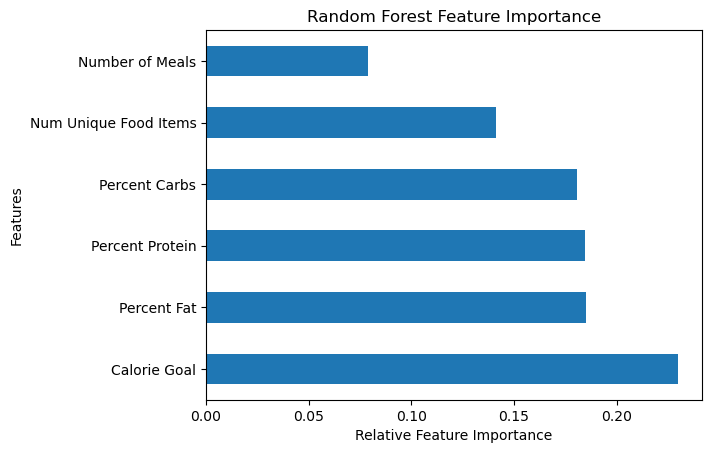

In [24]:
print(tree_model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(tree_model.feature_importances_, index=['Number of Meals', 'Num Unique Food Items', 'Percent Carbs', 'Percent Protein', 'Percent Fat', 'Calorie Goal'])
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.xlabel('Relative Feature Importance')
plt.ylabel('Features')
plt.show()

#### Macronutrient Total Values:
Features: ['calorie_total', 'carb_total', 'protein_total', 'fat_total']
- Random Forest:
    - Best score on kfold validation: 0.7382739214726137
    - Best Params: {'max_depth': 19}
    - Score on test set: 0.7455706199271452
    - No Skill ROC AUC 0.500
    - Model ROC AUC 0.843
    
- Logistic Regression:
    - Score on train set: 0.5993613541277185
    - Score on test set: 0.5999065540353358
    - No Skill ROC AUC 0.501
    - Model ROC AUC 0.657
    
    
 ### Macronutrient percent of calorie contributions
 Features: ['calorie_total', 'carb_pc', 'protein_pc', 'fat_pc']
 - Random Forest
    - score on kfold validation: 0.730
    - Best Params: {'max_depth': 19}
    - Score on test set: 0.738
    - No Skill ROC AUC 0.500
    - Model ROC AUC 0.823
    
 - Logistic Regression
    - Score on train set: 0.631
    - Score on test set: 0.630
    - No Skill ROC AUC 0.499
    - Model ROC AUC 0.686
    
- Nearest Neighbors
    - Train Accuracy: 0.782
    - Score on test set: 0.708
    - No Skill ROC AUC 0.500
    - Model ROC AUC 0.775
- Linear SVM
    - Train Accuracy: 0.663
    - Score on test set: 0.663
    - No Skill ROC AUC 0.501
    
- Neural Net
    - Train Accuracy: 0.6690107960328072
    - Score on test set: 0.6687868431100474
    - No Skill ROC AUC 0.501
    - Model ROC AUC 0.718
- AdaBoost
    - Train Accuracy: 0.680417473209475
    - Score on test set: 0.6812238664195714
    - No Skill ROC AUC 0.500
    - Model ROC AUC 0.716
- Naive Bayes
    - Train Accuracy: 0.6279818802258985
    - Score on test set: 0.6296132462912434
    - No Skill ROC AUC 0.500
    - Model ROC AUC 0.688
    
### Just macronutrient contributions
Features: ['meal_count', 'item_count', 'carb_pc', 'protein_pc', 'fat_pc', 'calorie_goal']

### Logistic Regression Clf

In [48]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5)
clf.fit(X=X_train, y=y_train)

clf.predict(X=X_train)
print(f'Score on train set: {clf.score(X_train, y=y_train)}')

calc_scores(clf, X_train, y_train, X_test, y_test)

Score on train set: 0.6689788669154477
Test Accuracy: 0.6693409448598914
              precision    recall  f1-score   support

       False       0.68      0.64      0.66    107219
        True       0.66      0.70      0.68    107543

    accuracy                           0.67    214762
   macro avg       0.67      0.67      0.67    214762
weighted avg       0.67      0.67      0.67    214762

ROC Score: 
0.6692964631796314


In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB



In [50]:
names = ["Neural Net", "AdaBoost",
         "Naive Bayes"]
# "RBF SVM", "Gaussian Process", 
classifiers = [
#      KNeighborsClassifier(7),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name)
    print('Train Accuracy: ' + str(clf.score(X_train, y_train)))
    calc_scores(clf, X_train,y_train, X_test, y_test, label=name, plotroc=False)
    print()

Neural Net
Train Accuracy: 0.6764562670870667
Test Accuracy: 0.6767584582002403
              precision    recall  f1-score   support

       False       0.74      0.55      0.63    107219
        True       0.64      0.80      0.71    107543

    accuracy                           0.68    214762
   macro avg       0.69      0.68      0.67    214762
weighted avg       0.69      0.68      0.67    214762

ROC Score: 
0.6765682227324994

AdaBoost
Train Accuracy: 0.6769870886631678
Test Accuracy: 0.6772613404606029
              precision    recall  f1-score   support

       False       0.70      0.61      0.65    107219
        True       0.66      0.75      0.70    107543

    accuracy                           0.68    214762
   macro avg       0.68      0.68      0.68    214762
weighted avg       0.68      0.68      0.68    214762

ROC Score: 
0.6771572717697821

Naive Bayes
Train Accuracy: 0.6429187204406218
Test Accuracy: 0.6431398478315531
              precision    recall  f1-score

In [51]:
#Create new KNN object
knn_2 = KNeighborsClassifier()
hyperparameters = {'n_neighbors': list(range(3, 20))}
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train, y_train)

print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best n_neighbors: 3


In [52]:
print('Train Accuracy: ' + str(best_model.score(X_train, y_train)))
calc_scores(best_model, X_train,y_train, X_test, y_test, label=name, plotroc=False)

Train Accuracy: 0.8788110394923271
Test Accuracy: 0.758458200240266
              precision    recall  f1-score   support

       False       0.82      0.66      0.73    107219
        True       0.72      0.86      0.78    107543

    accuracy                           0.76    214762
   macro avg       0.77      0.76      0.76    214762
weighted avg       0.77      0.76      0.76    214762

ROC Score: 
0.7583057191070943
